# ROSE tutorial: UQ for an Optical Potential!

One of the main justifications for building an emulator is to rapidly evaluate posteriors for Bayesian optimization and uncertainty-quantification. Often, our models have high dimensional parameter spaces, and are expensive to solve, so rigorously fitting free parameters to experiment would be computationally prohibitive. In this tutorial, we will use an emulator from `ROSE`, combined with the Bayesian optimization package `surmise`, which uses Markov-chain Monte Carlo (MCMC) to find the best fit values on the parameters space.

We will use the emulator with optimal configuration we found in the previous tutorial, with 15 basis elements and 15 terms in the affine decomposition, to quickly fit our optical potential parameters to a differential scattering cross section. First we quickly create our emulator, copying the problem setup from the previous tutorial:

In [1]:
# import ROSE to construct the emulator
import rose

# other nice things
import numpy as np
import time
import os
from scipy.stats import qmc

# import stuff for nice plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy.stats as sps
from tqdm import tqdm
import seaborn as sns
import random
import datetime

plt.rcParams.update({"font.size": 12})

In [2]:
A = 40  # mass of the target

AMU = 931.494102  # MeV/c^2, Particle Data Group
MASS_N = 1.008665 * AMU  # MeV/c^2 PDG
MASS_P = 1.007276 * AMU  # MeV/c^2 PDG
MASS_CHARGED_PION = 139.57039  # MeV/c^2
B_40CA = 342.0522  # BMEX

MASS_40CA = 20 * MASS_P + 20 * MASS_N - B_40CA
MU = (
    MASS_40CA * MASS_N / (MASS_40CA + MASS_N)
)  # reduced mass - we will do calculations in COM frame

# asymptotic energy and wavenumber in center-of-mass (COM) frame
energy = 14.1  # MeV
k = np.sqrt(2 * MU * energy) / rose.constants.HBARC

# how many partial waves should we calculate?
l_max = 10
l_list = list(range(l_max + 1))

# domain of the differential cross section; the observable we want to emulate
angles_fine = np.linspace(0, 180, 200)
# ROSE also has a convenient grid over radial space we can steal
rho = rose.constants.DEFAULT_RHO_MESH.copy()

In [3]:
# shape of interaction for volume term
def wood_saxon(r, R, a):
    return 1 / (1 + np.exp((r - R) / a))


# shape of interaction for surface-peaked and spin-orbit coupling terms
def wood_saxon_prime(r, R, a):
    return -1 / a * np.exp((r - R) / a) / (1 + np.exp((r - R) / a)) ** 2


# total potential with a real and central term (with the same geometry)
# and imaginary surface-peaked term, but no SO coupling
def optical_potential(r, theta):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (1j * Wv - Vv) * wood_saxon(r, Rv, av) - (4j * ad * Wd) * wood_saxon_prime(
        r, Rd, ad
    )


# spin orbit interaction constant
mso = rose.constants.HBARC / MASS_CHARGED_PION


# spin-orbit (SO) coulpling term - a function of l dot s, l being the orbital angular momentum
# and s being the spin of the neutron
def spin_orbit_potential(r, theta, ldots):
    Vv, Wv, Wd, Vso, Wso, Rv, Rd, Rso, av, ad, aso = theta
    return (Vso + 1j * Wso) * mso**2 * ldots * wood_saxon_prime(r, Rso, aso) / r


# the total number of parameters
nparams = 11

In [4]:
# This is the value of the parameters coming from the Koning-Delaroche parametrization.
# Taken from https://www-nds.iaea.org/RIPL-3/
VvKD = 46.7238
WvKD = 1.72334
WdKD = -7.2357
VsoKD = 6.1
WsoKD = -3.1

RvKD = 4.0538
RdKD = 4.4055
RsoKD = 1.01 * 40 ** (1.0 / 3.0)

avKD = 0.6718
adKD = 0.5379
asoKD = 0.60

alphaCentral = np.array(
    [VvKD, WvKD, WdKD, VsoKD, WsoKD, RvKD, RdKD, RsoKD, avKD, adKD, asoKD]
)

scaleTraining = 0.2

bounds = np.array(
    [
        alphaCentral - np.fabs(alphaCentral * scaleTraining),
        alphaCentral + np.fabs(alphaCentral * scaleTraining),
    ]
).T


def sample_points(npoints, bounds):
    sampler = qmc.LatinHypercube(d=len(bounds), seed=142857)
    sample = sampler.random(npoints)
    scaled = qmc.scale(sample, bounds[:, 0], bounds[:, 1])
    return scaled

Great, we have our potential and parameters set up. Before we create our emulator, let's take a look at the experimental data we want to fit.

## Experimental data for neutron scattering on $^{40}$Ca

Let's consider the practical example of fitting an optical potential to a differential elastic scattering cross section measurement. In particular, we will use [this measurement](http://dx.doi.org/10.1016/0029-5582(64)90087-2) from 1964 by McDonald and Robson, available [here on Exfor](https://www-nds.iaea.org/exfor/servlet/X4sGetSubent?reqx=207&subID=11611003&plus=1).


This was a measurement of 14 MeV neutrons incident on a $^{40}$Ca target. The outgoing neutrons - also at 14 MeV, remember, this is an elastic reaction - were then measured in one of an array of detectors, each set up a different scattering angle relative to the incident beam. From the density of the target and the incident flux of the beam, the authors reconstructed $\frac{d\sigma}{d\theta}$, the scattering cross section differentiated on the scattering angle (in the center-of-mass frame). Let's first take a look at this data, and then we'll talk about how to find the best-fit parameters and their uncertainties.



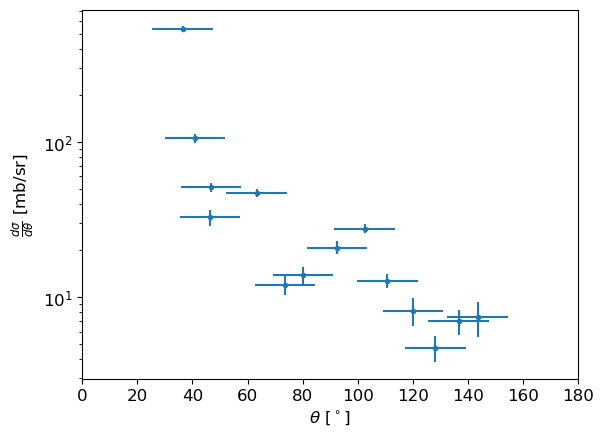

In [5]:
# Angles where d xs / s theta was measured, in degrees, 0 being transmission, 180 being reflection back to the beamline
anglesX = (
    180
    - (
        np.array(
            [
                0.93420,
                0.85630,
                0.76150,
                0.75470,
                0.46640,
                0.28740,
                0.17360,
                -0.0419,
                -0.2181,
                -0.3616,
                -0.5240,
                -0.6665,
                -0.8141,
                -0.9342,
            ]
        )
        + np.pi / 2
    )
    * 180
    / np.pi
)

# corresponding experimental cross sections
dxs = np.array(
    [
        5.34e02,
        1.06e02,
        3.27e01,
        5.10e01,
        4.69e01,
        1.20e01,
        1.39e01,
        2.09e01,
        2.77e01,
        1.28e01,
        8.2e00,
        4.7e00,
        7.0e00,
        7.4e00,
    ]
)

# experimental error
dxs_err = np.array(
    [
        2.3e01,
        7.0e0,
        4.0e0,
        3.5e0,
        2.9e0,
        1.7e0,
        1.7e0,
        2.0e0,
        1.8e0,
        1.4e0,
        1.7e0,
        9.0e-01,
        1.3e0,
        1.9e0,
    ]
)

angular_resolution = 11 # degrees

plt.yscale("log")
plt.errorbar(anglesX, dxs, dxs_err, xerr=angular_resolution, linestyle="none", marker=".")
plt.xlim([0, 180])
plt.xlabel(r"$\theta$ [$^\circ$]")
plt.ylabel(r"$\frac{d \sigma}{d \theta}$ [mb/sr]")
plt.show()

In [6]:
n_basis = 15
n_eim = 15

interactions = rose.InteractionEIMSpace(
    optical_potential,
    nparams,
    MU,
    energy,
    l_max,
    is_complex=True,
    spin_orbit_potential=spin_orbit_potential,
    training_info=bounds,
    n_basis=n_eim,
)

# how many training points do we want?
# the more we have, the longer the offline stage is
n_train = 50
training_samples = sample_points(n_train, bounds)

saeMCMC = rose.ScatteringAmplitudeEmulator.from_train(
    interactions,
    training_samples,
    l_max,
    n_basis=n_basis,
    angles=anglesX,
    hf_tols=[
        10 ** (-9),
        10 ** (-9),
    ],
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:08<00:00,  6.22s/it]
/home/kyle/umich/rose/src/rose/utility.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  return np.hstack([1/(2*s_c) * (3 - (s[ii]/s_c)**2), 1/s[jj]])


Great, we now have a trained emulator! Let's take a look at the experimental data we want to fit. Now our goal will be to fit an optical potential to this measurement!

## Specifying the prior:

In [7]:
# In this default we are assuming uncorrelated Gaussian priors. Advanced users can provide covariance matrices for correlations
# or even change the prior to a different form. We could even connect directly to the website that has the Koning-Delaroche
# parametrization and use that as a prior so the user only has to specify the system (like, Ca48 neutrons 20 MeV)

# We could find a way to modify the optical potential interaction above so that the entire 9 parameters are taken into account.
# Later,during the calibration time, if we want to freeze some parameters or make them equal to others (for example Rv=Rw) we
# can do it, but the freedom to not do that should be allowed


# Specifying the priors
alphaCentralPrior = alphaCentral

SigmasPrior = [abs(boundval * 0.5) for boundval in alphaCentralPrior]

# We use a smaller scale for the starting values of the MCMC chains so that we minimize the chances of one
# starting in a negative value of the diffuseness or the radii

MCMCScale = [abs(boundval * 0.1) for boundval in alphaCentralPrior]

# Going Bayesian with Surmise

In [8]:
from surmise.emulation import emulator
from surmise.calibration import calibrator

X = anglesX # domain
yperfect = dxs # data we want to fit
y = yperfect 
yerr = dxs_err # err in data

StepSizes0 = 0.004 * np.abs( alphaCentral )

numsamp = 5000
total_chains = 5
numcores = 8
BurnSamples0 = 500

In [9]:
class prior_scattering:
    """ This defines the class instance of priors provided to the method. """


    def lpdf(theta):
        
        total_prior_pdf=sps.norm.logpdf(theta[:, 0], alphaCentralPrior[0],SigmasPrior[0] )
        
        for i in range(1,len(alphaCentralPrior)):
            total_prior_pdf=total_prior_pdf+ sps.norm.logpdf(theta[:, i], alphaCentralPrior[i],SigmasPrior[i] )
            
            
            
        return (total_prior_pdf).reshape((len(theta), 1))


    def rnd(n):
        totalRandomSamples=[]
        for i in range(len(alphaCentralPrior)):
            totalRandomSamples.append(sps.norm.rvs( alphaCentralPrior[i], MCMCScale[i],   size=n))
        
        totalRandomSamplesNumpy=np.array(totalRandomSamples)
        
        return totalRandomSamplesNumpy.T
        
        
        
        
    
def rbm_emulator(x,theta):
    yList=[]
    for i in range(len(theta)):
        dsdo=saeMCMC.emulate_dsdo(theta[i])
        yList.append(dsdo)
    return np.array(yList).T

    
    
def calibration_runner(rbm,x,y,obsvar,test_params,numsamp,i,caldir):
   
    cal = calibrator(emu=rbm,
                   y=y,
                   x=x,
                   thetaprior=prior_scattering, 
                   method='directbayes',
                   yvar=obsvar, 
                   args={
                        'theta0': test_params.reshape(1,nparams),
                        'sampler': 'metropolis_hastings',
                         'numsamp' : numsamp,
                         'stepType' : 'normal',
                         'stepParam' : StepSizes0,
                        'burnSamples' : BurnSamples0
                   })
                       
 
    calfile = os.path.join(caldir,"caltheta_{}.out".format(i))
    np.savetxt(calfile,cal.info['thetarnd'])

    return cal.info['thetarnd']

In [10]:
random.seed(142857)

obsvar = np.maximum(1.0 * np.square(yerr), 1e-5)

caldir = os.path.join(
    os.getcwd(), "Cal-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
)
os.makedirs(caldir, exist_ok=True)

rand_params = prior_scattering.rnd(total_chains)

In [11]:
rbm = emulator(x=X, theta=alphaCentralPrior, passthroughfunc=rbm_emulator)
st = time.time()
all_chains = calibration_runner(rbm, X, y, obsvar, rand_params[0], numsamp, 0, caldir)

for ij in range(total_chains - 1):
    current_cal = calibration_runner(
        rbm, X, y, obsvar, rand_params[ij], numsamp, ij + 1, caldir
    )

    all_chains = np.vstack(
        (
            all_chains,
            current_cal,
        )
    )

    print("Percentage Completed ", int((ij + 1) / (total_chains - 1) * 100))

et = time.time()
print("Total time:", et - st)

Percentage Completed  25
Percentage Completed  50
Percentage Completed  75
Percentage Completed  100
Total time: 344.4986171722412


# Plotting the results of the calibration

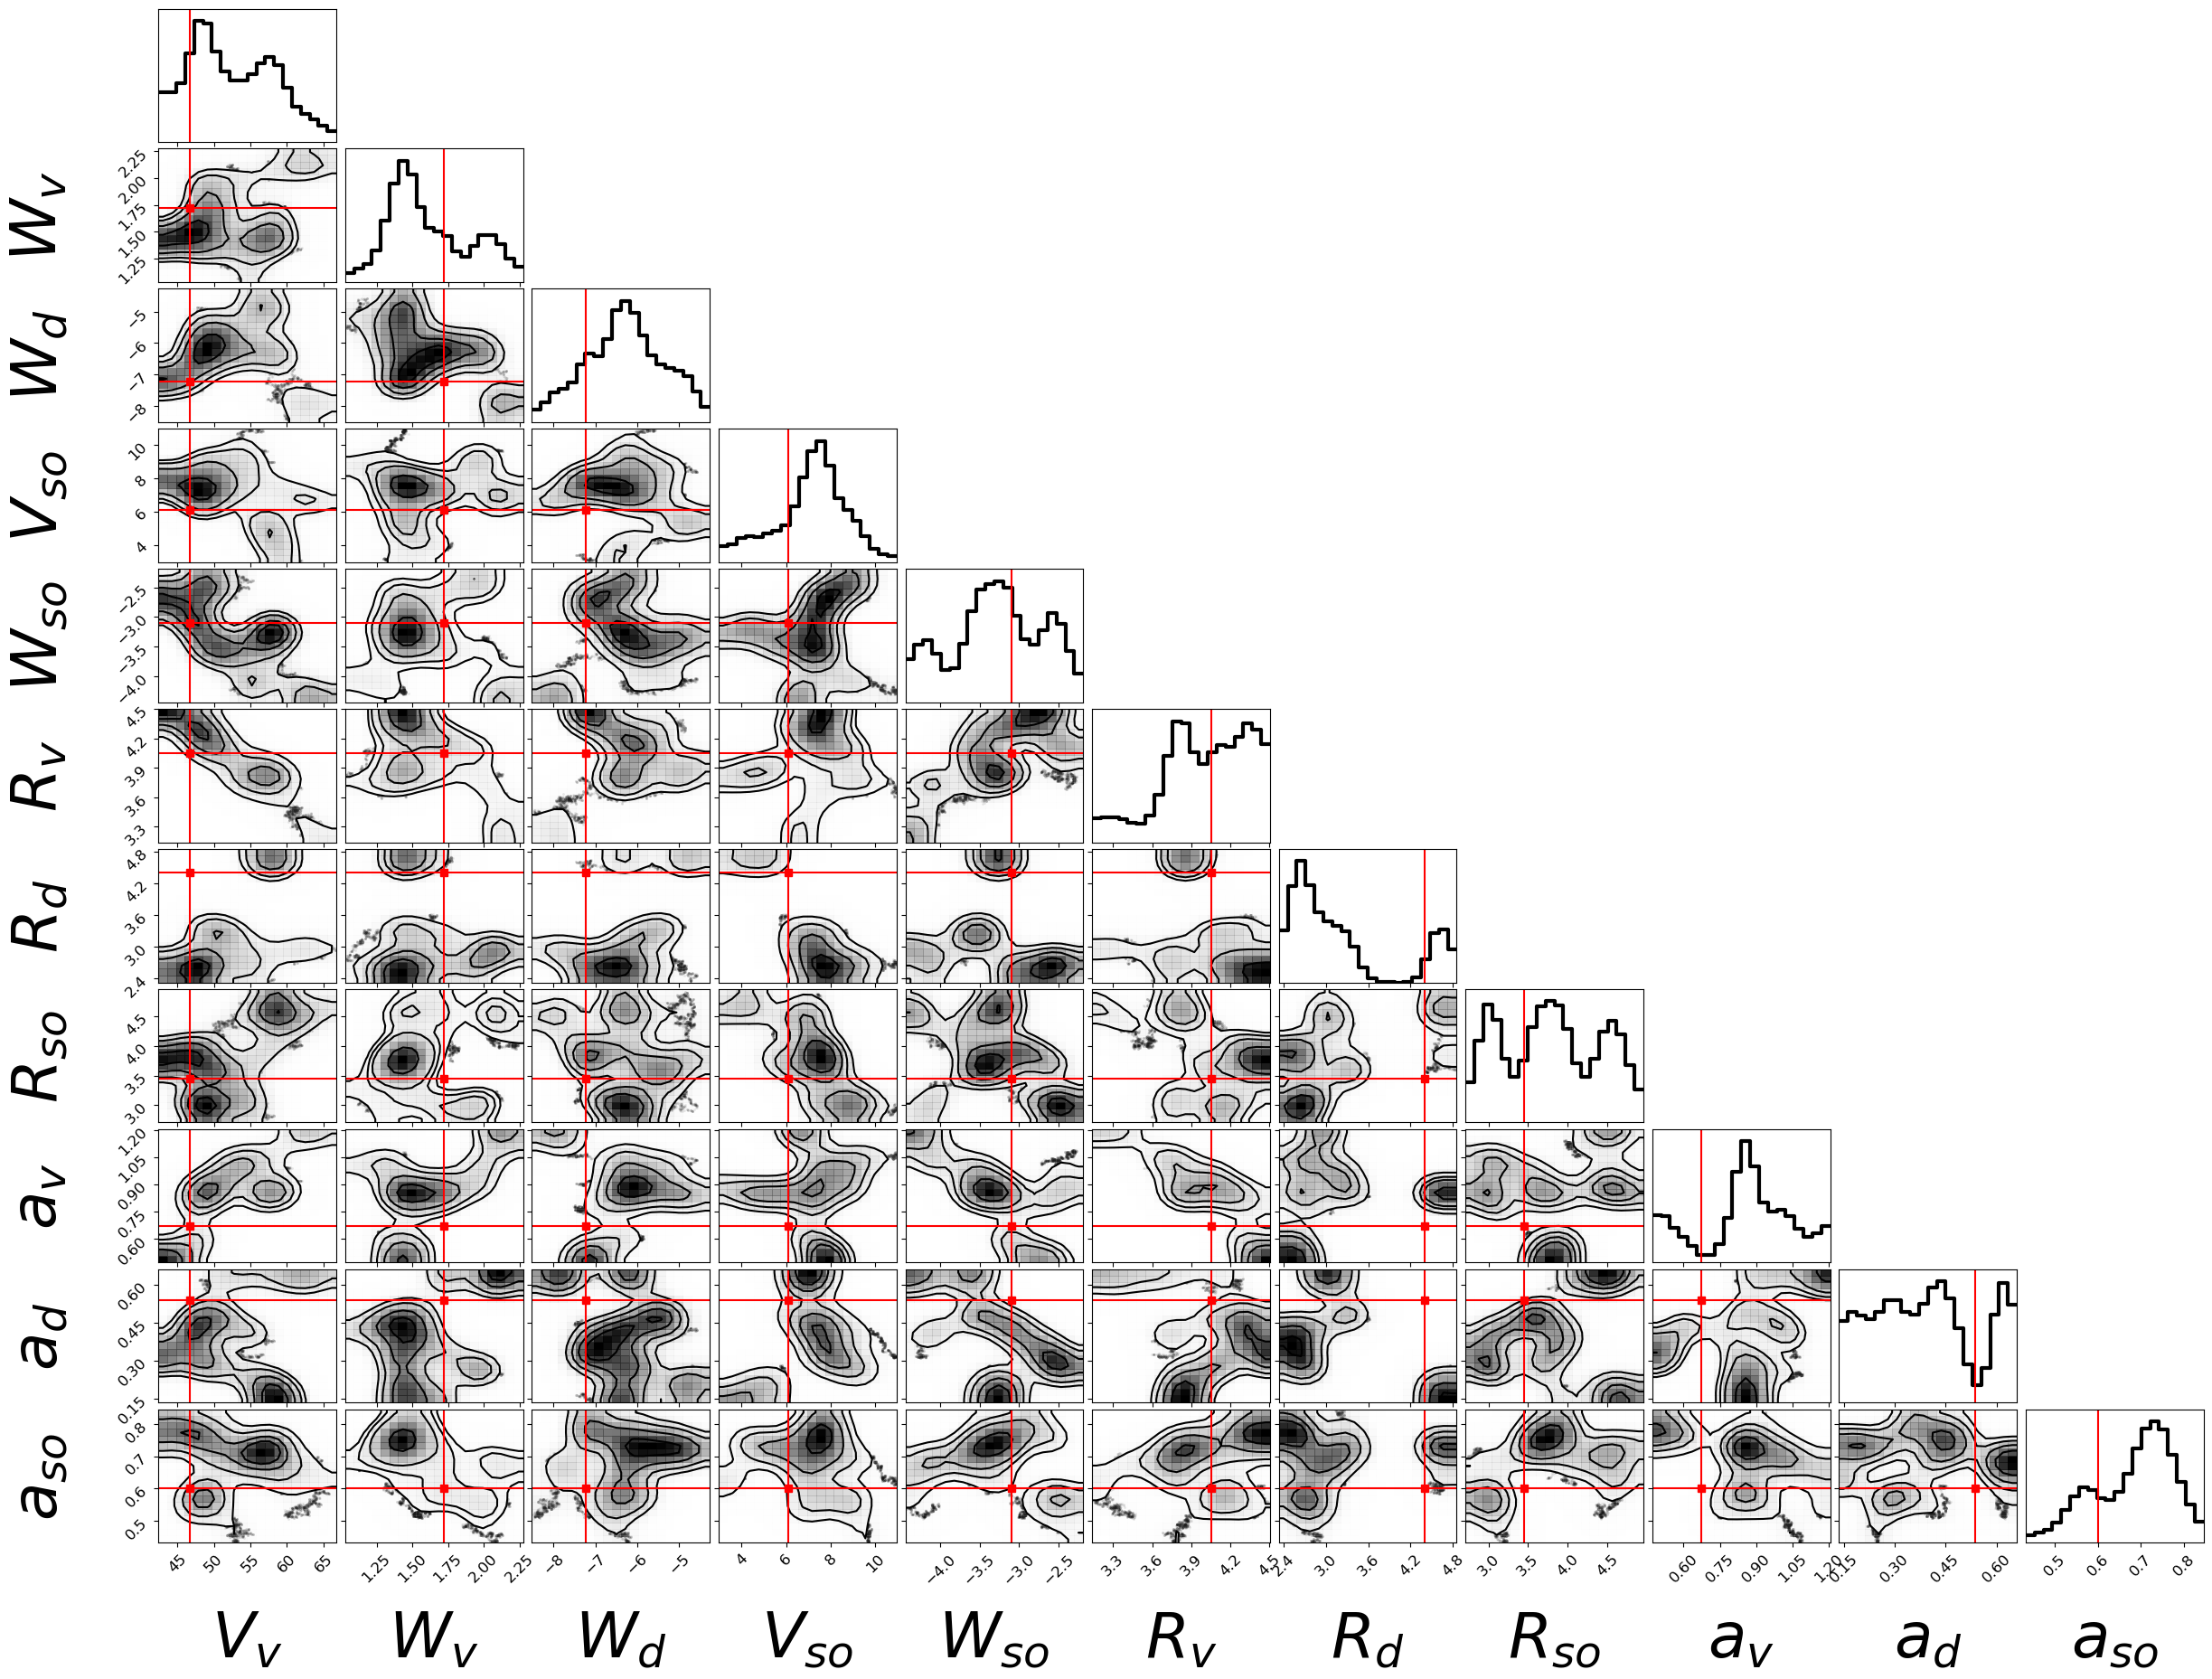

In [15]:
# The plotting routinge to make the gorgeous corner plots! For some reason we have to run it twice to make the label
# size for the ticks to be correct
import corner
figure = corner.corner(
    all_chains,
    labels=[
        "$V_v$",
        "$W_v$",
        "$W_d$",
        "$V_{so}$",
        "$W_{so}$",
        "$R_v$",
        "$R_d$",
        "$R_{so}$",
        "$a_v$",
        "$a_d$",
        "$a_{so}$",
    ],
    labelpad=0.2,
    bins=20,
    label_kwargs={"fontsize": 50},
    hist_kwargs={"linewidth": 3},
    quantiles=None,
    truths=alphaCentral,
    truth_color="r",
    smooth=(1.7),
    smooth1d=1.0,
)


width = 24
height = 18
figure.set_size_inches(width, height)
plt.rc("xtick", labelsize=30)
plt.rc("ytick", labelsize=30)

In [16]:
labelsChains = [
    "$V_v$",
    "$W_v$",
    "$W_d$",
    "$V_{so}$",
    "$W_{so}$",
    "$R_v$",
    "$R_d$",
    "$R_{so}$",
    "$a_v$",
    "$a_d$",
    "$a_{so}$",
]

In [17]:
XAll = np.arange(len(angles))
fig, axs = plt.subplots(nParams, 1, figsize=(12, 12))

for i in range(nParams):
    axs[i].plot(all_chains.T[i])
    axs[i].set_ylabel(labelsChains[i], fontsize=18)

plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.show()

NameError: name 'angles' is not defined

## Plotting our final calibrated model alongside the "data"

In [ ]:
XAll = np.arange(len(angles))

In [ ]:
# %#%time
rng = np.random.default_rng()
theta_rand = rng.choice(all_chains, (10000), replace=False)
rndm_m = rbm_emulator(XAll, theta_rand).T

In [ ]:
fig, naxs = plt.subplots(1, 1, figsize=(20, 10))
median = np.percentile(rndm_m, 50, axis=0)
upper = np.abs(np.percentile(rndm_m, 97.5, axis=0))

lower = np.abs(np.percentile(rndm_m, 2.5, axis=0))

naxs.plot(angles, median, color="C0")
naxs.fill_between(angles, lower, upper, color="C0", alpha=0.5)

naxs.scatter(anglesX, yperfect, s=100, c="r")
naxs.errorbar(anglesX, yperfect, yerr=2 * yerr, fmt="o", c="r")

naxs.set_yscale("log")

naxs.set_xlabel(r"$\theta$ (deg)", fontsize=50)
naxs.set_ylabel(r"$d\sigma/d\Omega$ [mb/sr] ", fontsize=50)

plt.text(100, 300, r"$^{40}\rm{Ca}(n,n)$", fontsize=100)


plt.rc("xtick", labelsize=50)  # fontsize of the tick labels
plt.rc("ytick", labelsize=50)


plt.show()